In [511]:
import yfinance as yf
import numpy as np
import pyextremes as pyx
import matplotlib.pyplot as plt
import pandas as pd
from arch import arch_model
from statsmodels.stats.diagnostic import (acorr_ljungbox)
import statsmodels.api as sm
from pyextremes import EVA
from scipy.stats import chi2

In [515]:
ticker = "^GSPC"
spdata = yf.download(ticker, start="2015-01-01", end="2025-01-01", interval="1d")
sp_data = spdata['Close']
print(sp_data.head())

[*********************100%***********************]  1 of 1 completed

Ticker            ^GSPC
Date                   
2015-01-02  2058.199951
2015-01-05  2020.579956
2015-01-06  2002.609985
2015-01-07  2025.900024
2015-01-08  2062.139893


In [516]:
sp_data1 = sp_data.reset_index("Date").set_index("Date")["^GSPC"]
print(sp_data1.head())

Date
2015-01-02    2058.199951
2015-01-05    2020.579956
2015-01-06    2002.609985
2015-01-07    2025.900024
2015-01-08    2062.139893
Name: ^GSPC, dtype: float64


In [508]:
log_returns_sp0 = np.log(sp_data1 / sp_data1.shift(1)).dropna()
log_returns_sp = log_returns_sp0[:1000]
test_log = log_returns_sp0[999:]

In [514]:
print(test_log.head())

Date
2018-12-21   -0.020803
2018-12-24   -0.027487
2018-12-26    0.048403
2018-12-27    0.008526
2018-12-28   -0.001242
Name: ^GSPC, dtype: float64


In [482]:
# functions
def hill_estimator(data, k):
    log_data = np.log(data[:k])
    return (1/k) * np.sum(log_data) - np.log(data[k])

def pickands_estimator(data, k):
    if 4*k >= len(data):
        return np.nan
    return 1/np.log(2) * np.log((data[k] - data[2*k])/(data[2*k] - data[4*k]))

def threshold_picking(data0):
    data = -data0[data0 < 0]
    thresholds = np.linspace(data.quantile(0.2), data.quantile(0.995), 200)
    pyx.plot_mean_residual_life(data, thresholds=thresholds)
    datas = np.sort(data)[::-1]
    k_values = range(4, int(len(datas)/1.3))

    hill_estimates = [hill_estimator(datas, k) for k in k_values]
    plt.figure(figsize=(10,6))
    plt.plot(k_values, hill_estimates, 'b-')

    pickands_estimates = [pickands_estimator(datas, k) for k in k_values]
    plt.figure(figsize=(10,6))
    plt.plot(k_values, pickands_estimates, 'r-', label="Pickands' ξ")
    return datas

def modeling(data0, u):
    data = -data0[data0 < 0]
    model = EVA(data)
    model.get_extremes(method="POT", threshold=u)
    model.fit_model(distribution="genpareto")
    print(model.model)
    model.plot_diagnostic()

    params = model.model.fit_parameters
    print(params)
    xi = params['c']
    sig = params['scale']
    return xi, sig

def prediction(params, data, u, level):
    xi = params[0]
    sig = params[1]
    data = -data
    p = level
    n_total = len(data)
    n_exceed = len([i for i in data if i > u])
    F_u = n_exceed / n_total
    print(F_u)
    p_u = F_u / p
    VaR = u + (sig / xi) * (p_u ** xi - 1)
    ES = ES = (VaR + (sig - xi * u)) / (1 - xi)
    return VaR, ES


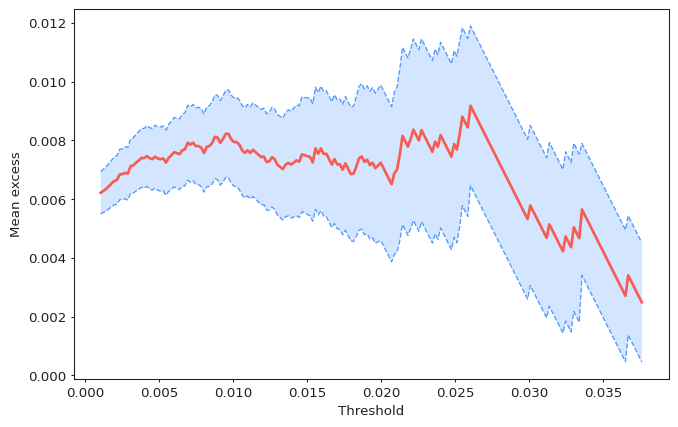

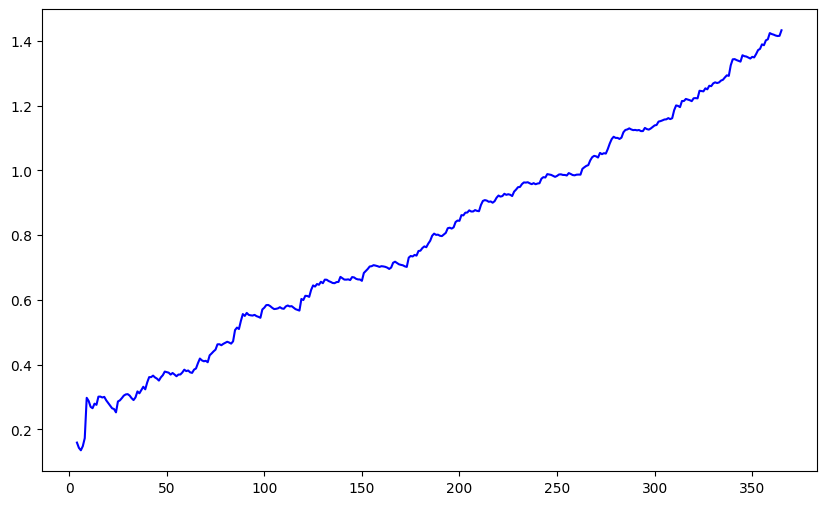

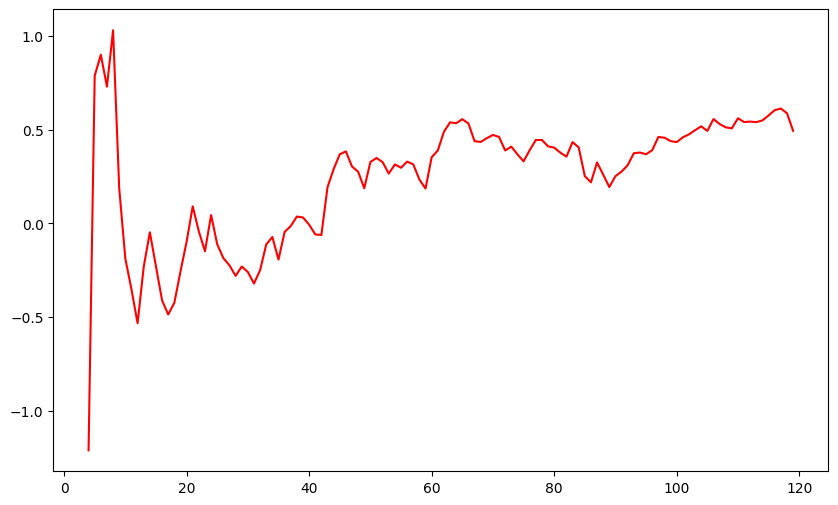

In [483]:
sorted_static_sp = threshold_picking(log_returns_sp)

In [484]:
u_static_sp = sorted_static_sp[250]
print(u_static_sp)

0.0030160187399297005


              MLE model              
-------------------------------------
free parameters: c=0.081, scale=0.007
fixed parameters: floc=0.003         
AIC: -1592.187                       
loglikelihood: 798.123               
return value cache size: 0           
fit parameter cache size: 0          
-------------------------------------
{'c': np.float64(0.0805120750767265), 'scale': np.float64(0.006785937357841749)}
(np.float64(0.0805120750767265), np.float64(0.006785937357841749))


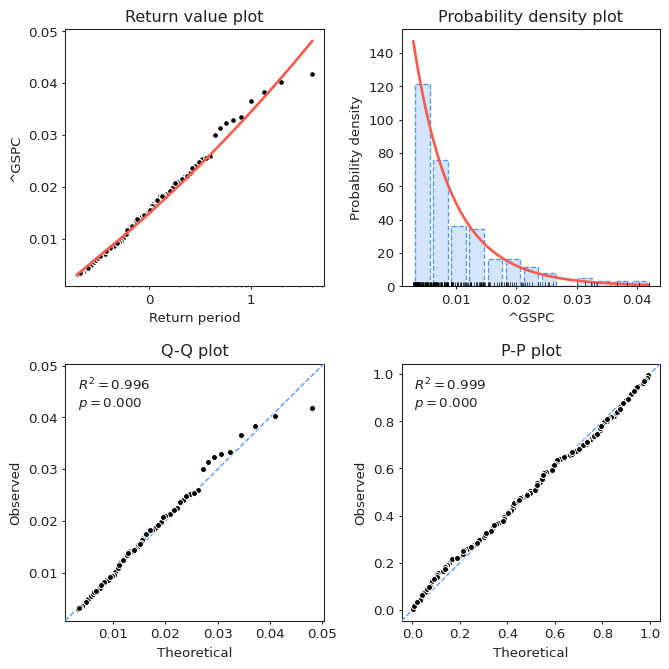

In [485]:
params3 = modeling(log_returns_sp, u_static_sp)
print(params3)

In [527]:
VaR_sb, ES_sb = prediction(params3, log_returns_sp, u_static_sp, 0.01)
print(VaR_sb, ES_sb)

0.25
0.027950725866568576 0.037514181929106494


Iteration:      1,   Func. Count:      6,   Neg. LLF: 73622515167.20412
Iteration:      2,   Func. Count:     19,   Neg. LLF: 18012280039983.965
Iteration:      3,   Func. Count:     33,   Neg. LLF: 255300878285.48813
Iteration:      4,   Func. Count:     48,   Neg. LLF: 48391534847226.33
Iteration:      5,   Func. Count:     63,   Neg. LLF: 266109444.86346868
Iteration:      6,   Func. Count:     76,   Neg. LLF: 6803953920559.422
Iteration:      7,   Func. Count:     91,   Neg. LLF: 4853792.698584864
Iteration:      8,   Func. Count:    104,   Neg. LLF: 229934755438.7489
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3497.127007059292
            Iterations: 10
            Function evaluations: 114
            Gradient evaluations: 8
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  ^GSPC   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-square

/Users/workman/Desktop/pypro/T02_venv/lib/python3.11/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 7.143e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


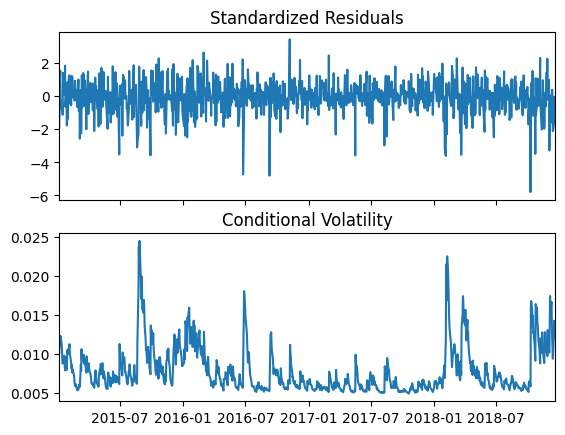

    lb_stat  lb_pvalue
1  0.239165    0.62481
Ljung-Box test on squared residuals:
   lb_stat  lb_pvalue
1  1.31437   0.251605


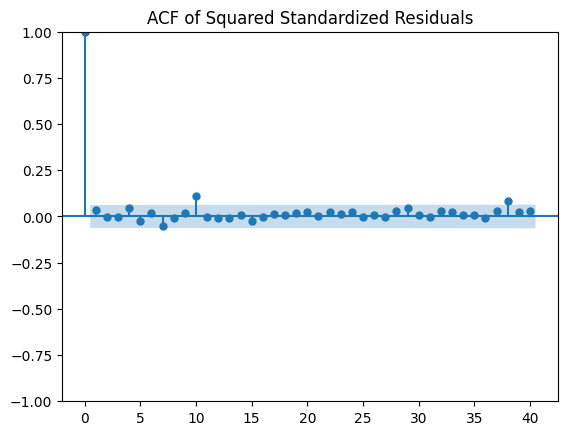

In [498]:
model3 = arch_model(log_returns_sp, vol='Garch', p=1, q=1)
results2 = model3.fit()
print(results2.summary())
results2.plot()
plt.show()
standardized_resid2 = results2.resid / results2.conditional_volatility
sigma_train = results2.conditional_volatility

ljung_box = acorr_ljungbox(standardized_resid2, lags=1, return_df=True)
print(ljung_box)

squared_resid2 = standardized_resid2**2
lb_test_squared2 = acorr_ljungbox(squared_resid2, lags=1, return_df=True)
print("Ljung-Box test on squared residuals:")
print(lb_test_squared2)

sm.graphics.tsa.plot_acf(squared_resid2, lags=40)
plt.title('ACF of Squared Standardized Residuals')
plt.show()

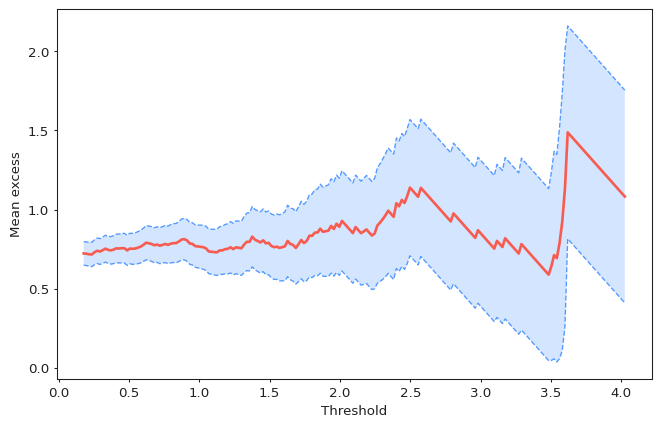

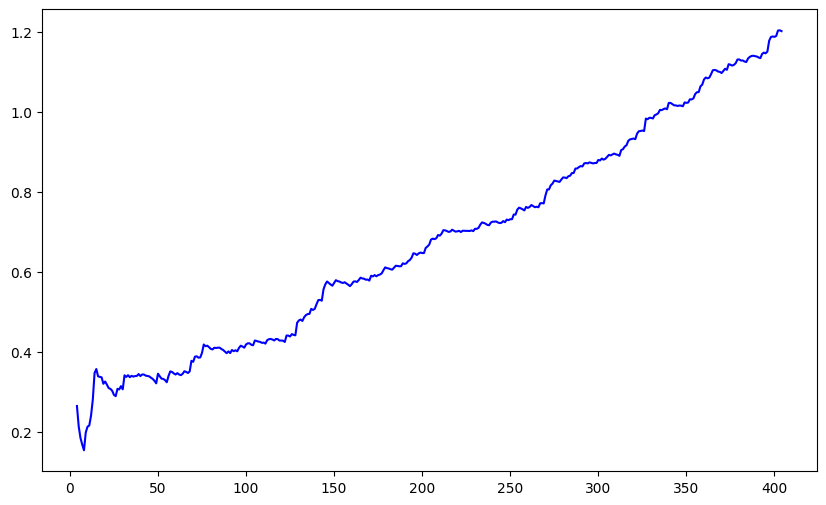

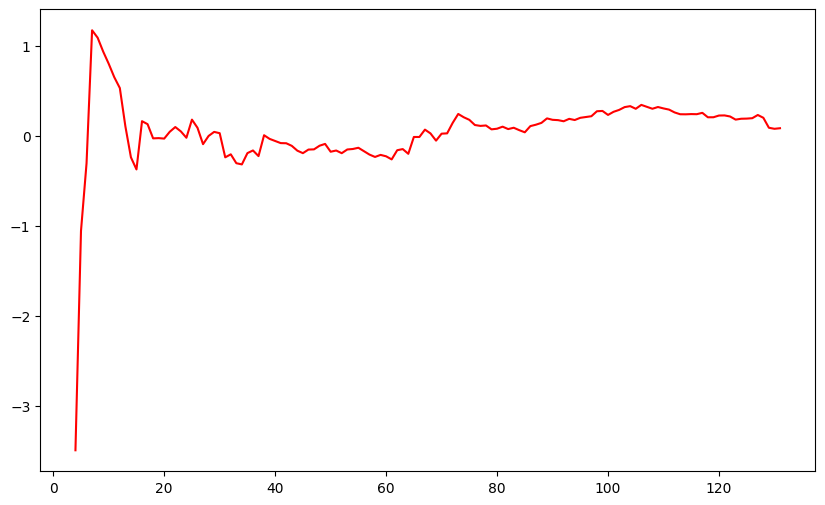

In [488]:
sorted_d_sp = threshold_picking(standardized_resid2)

In [494]:
u_d_sp = sorted_d_sp[150]
print(u_d_sp)

0.8738833731920419


              MLE model               
--------------------------------------
free parameters: c=-0.017, scale=0.870
fixed parameters: floc=0.874          
AIC: 225.033                          
loglikelihood: -110.469               
return value cache size: 0            
fit parameter cache size: 0           
--------------------------------------
{'c': np.float64(-0.01714635331596978), 'scale': np.float64(0.8697525951222308)}
(np.float64(-0.01714635331596978), np.float64(0.8697525951222308))


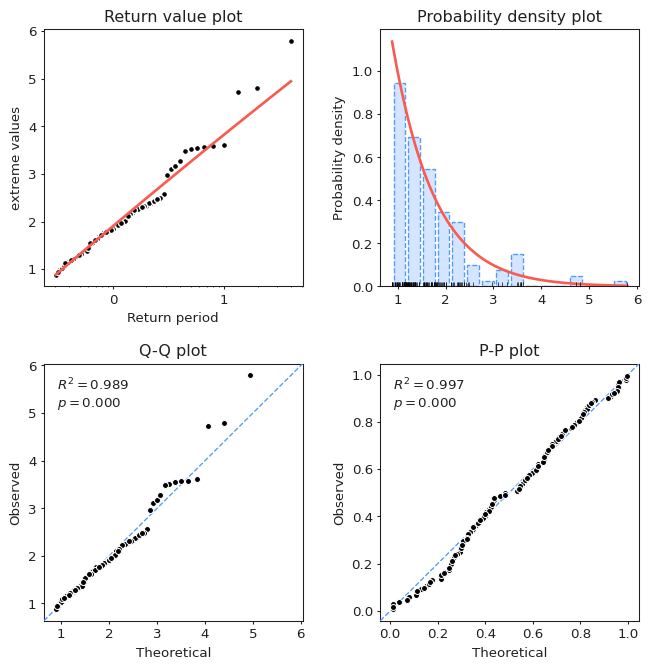

In [495]:
params4 = modeling(standardized_resid2, u_d_sp)
print(params4)

In [496]:
VaR_db, ES_db = prediction(params4, standardized_resid2, u_d_sp, 0.01)
print(VaR_db, ES_db)

0.15
3.1753708717575324 3.991664883541317


In [530]:
sigma_test = [sigma_train.iloc[-1]]

VaR = []
omega, alpha, beta_garch = results2.params[["omega", "alpha[1]", "beta[1]"]]
for x_t in test_log[:-1]:
    sigma_t = sigma_test[-1]
    sigma_t1 = np.sqrt(omega + alpha * x_t**2 + beta_garch * sigma_t**2)
    sigma_test.append(sigma_t1)

    var_t1 = sigma_t1 * VaR_db
    VaR.append(var_t1)

X_test = test_log[1:]
VaR_series = pd.Series(VaR, index=X_test.index)

# Record hits
hits = X_test > VaR_sb
hit_rate = hits.mean()

n = len(hits)
x = hits.sum()
pi_hat = hit_rate
alpha = 0.01

ll_null = x * np.log(alpha) + (n - x) * np.log(1 - alpha)
ll_alt = x * np.log(pi_hat) + (n - x) * np.log(1 - pi_hat)
LR_uc = -2 * (ll_null - ll_alt)
p_val = 1 - chi2.cdf(LR_uc, df=1)
print(p_val)

0.33890948643718577
